# Ce Notebook a pour but de répondre au point suivant :

 - 1) Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à venir. Automatiser ces traitements pour éviter de répéter ces opérations.
 
C'est un Noteboook de nettoyage des données du dataset principal.

## List of fields:

### general information:

 - code : barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix
 - url : url of the product page on Open Food Facts
 - creator : contributor who first added the product
 - created_t : date that the product was added (UNIX timestamp format)
 - created_datetime : date that the product was added (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
 - last_modified_t : date that the product page was last modified
 - last_modified_datetime
 - product_name : name of the product
 - generic_name
 - quantity : quantity and unit

### tags:

 - packaging : shape, material
 - packaging_tags
 - brands
 - brands_tags
 - categories
 - categories_tags
 - categories_fr
 - origins : origins of ingredients
 - origins_tags
 - manufacturing_places : places where manufactured or transformed
 - manufacturing_places_tags
 - labels
 - labels_tags
 - labels_fr
 - emb_codes
 - emb_codes_tags
 - first_packaging_code_geo : coordinates corresponding to the first packaging code indicated
 - cities
 - cities_tags
 - purchase_places
 - stores
 - countries : list of countries where the product is sold
 - countries_tags
 - countries_fr
 
### ingredients:

 - ingredients_text
 - traces
 - traces_tags

### misc. data:

 - serving_size : serving size in g
 - no_nutriments : indicates if the nutrition facts are indicated on the food label
 - additives_n : number of food additives
 - additives
 - additives_tags
 - ingredients_from_palm_oil_n
 - ingredients_from_palm_oil
 - ingredients_from_palm_oil_tags
 - ingredients_that_may_be_from_palm_oil_n
 - ingredients_that_may_be_from_palm_oil
 - ingredients_that_may_be_from_palm_oil_tags
 - nutrition_grade_fr : nutrition grade ('a' to 'e'). see http://fr.openfoodfacts.org/score-nutritionnel-experimental-france
 - main_category
 - main_category_fr
 - image_url
 - image_small_url

### nutrition facts:
 
#### Eléments à privilégier pour le Nutri-Score :
 
 - proteins_100g
 - fiber_100g
 - fruits-vegetables-nuts_100g
 
#### Eléments à limiter pour le Nutri-Score :
 
 - energy_100g
 - saturated-fat_100g
 - sugars_100g
 - sodium_100g
 

In [1]:
#On commence par importer les librairies utiles à l'analyse

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyarrow

In [2]:
#On stocke le dataset principal dans une variable
data = pd.read_csv("en.openfoodfacts.org.products.csv", sep = '\t', low_memory=False)

In [3]:
data.shape

(928716, 175)

# Définitions des fonctions de nettoyage et filtrage :

In [4]:
#Fonction de filtrage d'un dataset

#En arguments, on trouve :
# - Le dataframe à analyser
# - La colonne à filtrer
# - La chaîne à rechercher
# La fonction retourne un nouveau dataframe

def Filtre(df,colonne,chaine):
    
    filtre_data = df[df[colonne].str.contains(chaine,case=False, na=False)]

    return filtre_data

In [5]:
#Fonction qui retourne la liste des colonnes de la catégorie nutrition
def Champs_nutrition(df):
    
    liste_colonnes_nutrition = df.loc[:,df.columns.str.contains('100g',case=False, na=False)]
    liste_colonnes_nutrition = list(liste_colonnes_nutrition.columns)

    return liste_colonnes_nutrition

In [6]:
#Fonction qui sert remettre au bon format les valeurs dans les champs nutritions de la BDD
#Teste si la valeur est un float. Si la valeur est un string alors on la reformate en float.

def Format_valeur(valeur):
    
    #Pour éviter les noms de colonnes
    
    #On teste le format de la valeur
    if valeur < 0:

        #print(valeur)
        #S'il y a un g, on l'enlève
        valeur = 0
        return float(valeur)

    else:

        #Sinon on renvoie simplement la valeur
        #try:
        return float(valeur)      
        #S'il y a une erreur, la valeur est un Nan
        #except:
        #    return np.Nan

In [7]:
#Fonction de recherche de valeurs abérrantes et atypiques
#Cette fonction est utilisée dans la section Nutrition Facts. Les données sont censées être des valeurs pour 100g de produit.
#Barême :
# - Si les valeurs sont comprises entre 100 et 150, elles seront ramenées à la valeur 100. Ce sont des valeurs atypiques.
# - Si les valeurs sont supérieures à 150. Les lignes seront supprimées. Ce sont des valeurs abérrantes.

def Valeurs_aber_atyp(valeur):
    
    #print("Il y a {} valeurs atypiques qui ont été traitées.".format(len(df[(df[colonne] > 100) & (df[colonne] <= 120)].count()))
    #print('')
    #Traitement des valeurs atypiques
    valeur = pd.to_numeric(valeur)
    
    if (valeur > 100 and valeur <= 150):
        
        valeur_modif = 100
        return valeur_modif
    elif float(valeur) > 150:
        
        #print(valeur)
        valeur_modif = np.nan
        return valeur_modif

    #df.replace(df[(df.loc[:,liste_colonnes_nutrition[0]:liste_colonnes_nutrition[-1]] > 100) & (df.loc[:,liste_colonnes_nutrition[0]:liste_colonnes_nutrition[-1]] <= 150)],100,inplace = True)
    
    #df[(df.loc[:,liste_colonnes_nutrition[0]:liste_colonnes_nutrition[-1]] > 100) | (df.loc[:,liste_colonnes_nutrition[0]:liste_colonnes_nutrition[-1]] <= 120)] = 100
    #nbr_ligne_avant_traitement = df.shape[0]
    
    #Traitement des valeurs abérrantes
    #df.drop(df.loc[:,colonne[0]:colonne[-1]] > 120, inplace=True)
    
    #print("Il y a {} valeurs abérrantes (outliers) qui ont été supprimées.".format(nbr_ligne_avant_traitement - df.shape[0]))
    #print('')


In [8]:
#Fonction de recherche de lignes dupliquées
#Cette fonction recherche les lignes dupliquées entièrement.
def Lignes_dupliquees_entieres(df):

    nbr_ligne = df.loc[df.duplicated(keep=False),:].shape[0]
    print("Il y a {} lignes complètes en doublon.".format(nbr_ligne))

    df.drop_duplicates(keep='first')
    print("Il y a {} lignes complètes supprimées.".format(int(nbr_ligne / 2)))

In [9]:
#Fonction de recherche de lignes dupliquées
#Cette fonction recherche les lignes dupliquées sur un indicateur en particulier.

#Pour les lignes dupliquées suivant une colonne, on garde celle avec le plus de données dans la catégorie 'nutrition Facts'

def Lignes_dupliquees_indicateur(df,colonne):
     
    #On recherche les lignes dupliquées sur l'indicateur 'code'
    df_lignes_duppliquees = df.loc[df.duplicated(subset=[colonne],keep=False),:]
    print("Il y a {} références en doublon sur l'indicateur {}.".format(df_lignes_duppliquees.shape[0], colonne))

    #On liste les colonnes contenant la chaine '100g' qui correspondent à la catégorie 'nutrition facts'
    liste_colonnes_nutrition = df_lignes_duppliquees.loc[:,df_lignes_duppliquees.columns.str.contains('100g',case=False, na=False)]
    liste_colonnes_nutrition = list(liste_colonnes_nutrition.columns)
     
    #On liste ensuite les code-barres dupliqués pour ensuite les traiter un à un
    liste_doublons = list(df_lignes_duppliquees[colonne].unique())

    #On ne garde que la ligne contenant le plus de données qui nous concernent pour notre application
    #Si la comparaison donne un résultat égal, alors on garde que la première ligne
    
    #A REVOIR : CET ALGORYTHME NE FONCTIONNE QUE POUR DES LIGNES DUPLIQUEES 2 FOIS
    #A ADAPTER POUR UNE PLUS GRANDE FLEXIBILITE AVEC UNE BOUCLE FOR SUR df_doublon
    for doublon in liste_doublons:

        df_doublon = df_lignes_duppliquees[df_lignes_duppliquees[colonne] ==  doublon]
        
        #On compte le nombre de valeurs non nulles dans les colonnes nutritions
        test = df_doublon.loc[1:,liste_colonnes_nutrition[0]:liste_colonnes_nutrition[-1]].count(axis='columns')
        
        ##On teste le nombre de données renseignées sur les deux lignes sélectionnées
        if test.index[0] > test.index[1]:
            df.drop(df_doublon.index[0], inplace=True)
            
        elif test.index[0] < test.index[1]:
            df.drop(df_doublon.index[1], inplace=True)
            
        elif test.index[0] == test.index[1]:
            df.drop(df_doublon.index[1], inplace=True)
    

    print("Il y a {} lignes en doublon supprimées.".format(int(len(liste_doublons) / 2)))
    print("Il reste {} lignes dans le dataframe.".format(df.shape[0]))


# Définitions des fonctions de création de graphiques :

In [10]:
#Ceci est une fonction permettant de tracer un camembert
# Pie chart

def chart_pie(labels, sizes, colors, explode, title):
    
    labels = labels
    sizes = sizes

    # only "explode" the 2nd slice (i.e. 'Hogs')
    explode = explode

    #add colors
    colors = colors

    fig1, ax1 = plt.subplots(figsize=(9, 6))

    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=140)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')
    plt.title(title, bbox={'facecolor':'0.8', 'pad':5})
    plt.tight_layout()
    plt.show()

# Création d'une application de prédiction de NutriScore :

Cette application est destinée au service de la santé française.

## 1/ Décrire et nettoyer la BDD :

 - Site où télécharger la BDD : https://fr.openfoodfacts.org/
 - Un dataset au format CSV : https://fr.openfoodfacts.org/data/fr.openfoodfacts.org.products.csv
 - 928716 lignes. 1 ligne = 1 produit
 - 175 colonnes. Les données sont classées en 4 catégories. Descriptions : https://world.openfoodfacts.org/data/data-fields.txt
 

### Nombre de pays dans lesquels sont vendus les produits :

In [10]:
#On recherche la liste des pays concernés dans la BDD
liste_pays = pd.DataFrame(data['countries_fr'].unique())
print("Il y a {} ligne à l'extraction.".format(liste_pays.shape[0]))

liste_pays = liste_pays.dropna()

for i in liste_pays.itertuples():
    if ',' in i[1]:
        liste_pays = liste_pays.drop(i[0])
        
print('')
print("Il y a {} pays dans lesquels des produits sont vendus dans la BDD.".format(liste_pays.shape[0]))
print('')
print('')

Il y a 1820 ligne à l'extraction.

Il y a 214 pays dans lesquels des produits sont vendus dans la BDD.




Dans un soucis de réduction de taille de la BDD initiale, nous travaillerons uniquement sur les produits vendus en France.

### Nombre de produits vendus en France :

In [11]:
# On appelle la fonction de filtrage
vendus_France = Filtre(data,'countries_fr','France')

print("Il y a {} produits vendus en France avant nettoyage des lignes dupliquées.".format(vendus_France.shape[0]))
print('')

Il y a 589303 produits vendus en France avant nettoyage des lignes dupliquées.



#### Traitement du format des champs :

Dans un premier temps, on vérifie que les valeurs inscrites dans la catégorie nutrition facts sont bien des float.
Si ce n'est pas le cas, on le reformate, et on le passe en float.

In [12]:
liste_colonnes = Champs_nutrition(data)

#Hypothèse 1 :
#data_nettoye = vendus_France.copy()
#Hypothèse 2:
data_nettoye = data.copy()

for i in liste_colonnes:
    
    #print("Traitement de la colonne {}.".format(i))
    
    data_nettoye[i] = data[i].apply(Format_valeur)


In [13]:
data_nettoye.shape

(928716, 175)

#### Traitement des lignes dupliquées :

Dans un second temps, on s'occupe des lignes dupliquées en deux étapes :
 - La première en supprimées deux lignes parfaitement identiques.
 - La seconde en identifiant les produits avec le même code barre. On gère ces doublons en ne gardant que ceux qui ont le plus de données dans la catégorie nutrition facts.

In [14]:
#On appelle les fonctions de traitement
Lignes_dupliquees_entieres(data_nettoye)
print('')

Lignes_dupliquees_indicateur(data_nettoye,'code')
print('')

Il y a 26 lignes complètes en doublon.
Il y a 13 lignes complètes supprimées.

Il y a 322 références en doublon sur l'indicateur code.
Il y a 80 lignes en doublon supprimées.
Il reste 928555 lignes dans le dataframe.



#### Traitement des outliers et valeurs atypiques :

La troisième étape consiste à traiter les valeurs atypiques et les valeurs abbérantes (outliers) :
 - Valeur atypique : Les valeurs n'étant pas censées être > 100, celes comprises entre 100 et 150 seront ramenées à une valeur de 100.
 - Valeur abbérante : Les valeurs abbérantes seront transformées en np.Nan

#### Calcul du nombre d'outliers en énergie

Qu'est ce qu'un outlier en énergie nutritionnelle?
 - L'énergie nutritionnelle est indiquée en Kj dans la base Open Food Fact
 - La moyenne nutritionnelle journalière pour un adulte est d'environ 2000kcal
 - La conversion est la suivante : 1kJ = 0.239kcal
 - Nous pouvons rechercher des outliers à partir de 2000kcal (8373,6kJ) pour 100g de produit. Ensuite nous procèderons par pallier pour déterminer d'une limite raisonnable à traiter

In [15]:
df_energy = pd.DataFrame(data_nettoye.loc[:,liste_colonnes[0]])
df_energy[df_energy > 8400].count().sum()

130

#### Calcul du nombre d'outliers dans les données nutritionnelles

Les données nutritionnelles représentent 100g de produits. Si leur valeur est au dessus cela veut dire qu'il y a une erreur dans la base.

Examinons par palliers les outliers.


In [16]:
df_temp = data_nettoye.loc[:,liste_colonnes[1]:liste_colonnes[-1]]
print("Nombre d'outliers au dessus de 100g :", df_temp[df_temp > 100].count().sum())
print("Nombre d'outliers au dessus de 150g :", df_temp[df_temp > 150].count().sum())
print("Nombre d'outliers au dessus de 200g :", df_temp[df_temp > 200].count().sum())
print("Nombre d'outliers au dessus de 300g :", df_temp[df_temp > 300].count().sum())
print("Nombre d'outliers au dessus de 500g :", df_temp[df_temp > 500].count().sum())

Nombre d'outliers au dessus de 100g : 9981
Nombre d'outliers au dessus de 150g : 8662
Nombre d'outliers au dessus de 200g : 7784
Nombre d'outliers au dessus de 300g : 6629
Nombre d'outliers au dessus de 500g : 4399


In [17]:
print("Il y a {} valeurs Nan dans la catégorie 'nutrition facts'.".format(data_nettoye.isna().sum().sum()))

nbr_outlier = df_temp[df_temp > 100].count().sum() + df_energy[df_energy > 8400].count().sum()
print("Il y a {} outliers à traiter.".format(nbr_outlier))

#nbr_atyp = df_temp[(df_temp > 100) & (df_temp <= 150)].count().sum()
#print("Il y a {} valeurs atypiques à traiter.".format(nbr_atyp))

df_energy[df_energy > 8400] = np.nan

#On passe les outliers à 0
df_temp[df_temp > 100] = 0

#df_temp[(df_temp > 100) & (df_temp <= 150)] = 100

#On supprime les anciennes colonnes de la catégorie nutrition facts, pour les remplacer ensuite
data_nettoye.drop(liste_colonnes ,axis=1, inplace = True)

#On rajoute les colonnes après traitement.
data_nettoye = pd.concat([data_nettoye,df_energy], axis=1)
data_nettoye = pd.concat([data_nettoye,df_temp], axis=1)

print("Il y a {} valeurs Nan dans la catégorie 'nutrition facts' après traitement.".format(data_nettoye.loc[:,liste_colonnes[0]:liste_colonnes[-1]].isna().sum().sum()))
print('')

Il y a 128863787 valeurs Nan dans la catégorie 'nutrition facts'.
Il y a 10111 outliers à traiter.
Il y a 91758583 valeurs Nan dans la catégorie 'nutrition facts' après traitement.



#### Création du dataframe de travail

On ne va garder que les colonnes en rapport avec l'application. A savoir les variables de la catégorie 'Nutrition facts', plus quelques autres indicateurs :
 - Le groupe NOVA qui nous aidera à prédire à quel groupe appartient un nouveau produit.
 - Le groupe nutritionnel
 - Le nom des produits

In [18]:
#On sélectionne les variables de la catégories nutrition facts

liste_colonnes = Champs_nutrition(data_nettoye)
df_travail = data_nettoye.loc[:,liste_colonnes[0]:liste_colonnes[-1]]

#On rajoute le groupe nutritionnel
df_travail['nutrition_grade_fr'] = data_nettoye['nutrition_grade_fr']

#On rajoute le nom du produit
df_travail['product_name'] = data_nettoye['product_name']

#On supprime la colonne nutrition-score-uk_100g, qui est doublon pour notre application
df_travail.drop('nutrition-score-uk_100g',axis=1,inplace=True)

print("Il y a {} colonnes dans le dataset de travail avant traitement.".format(df_travail.shape[1]))

Il y a 108 colonnes dans le dataset de travail avant traitement.


#### Traitement des Nan

On enlève les lignes et les colonnes complètement vides.

In [19]:
liste_colonnes = Champs_nutrition(df_travail)

nbr_lignes_avant_traitement = df_travail.shape[0]
nbr_colonnes_avant_traitement = df_travail.shape[1]

print("Il y a {} lignes et {} colonnes dans le dataframe.".format(nbr_lignes_avant_traitement,nbr_colonnes_avant_traitement))
print('')

#On supprime les colonnes contenant les données nutritionnelles vides
df_travail = df_travail.dropna(axis = 1, how = 'all')
nbr_colonnes_apres_traitement = df_travail.shape[1]
print("{} colonnes supprimées.".format(nbr_colonnes_avant_traitement - nbr_colonnes_apres_traitement))  
print("Il reste {} colonnes dans le dataframe.".format( df_travail.shape[1]))
print('')

#On supprime les lignes contenant les données nutritionnelles vides 
df_travail.loc[:,liste_colonnes[0]:liste_colonnes[-1]].dropna(axis = 0, how = 'all')
df_travail = df_travail.reset_index(drop=True)

nbr_lignes_apres_traitement = df_travail.shape[0]
print("{} lignes supprimées.".format(nbr_lignes_avant_traitement - nbr_lignes_apres_traitement))
print("Il reste {} lignes dans le dataframe.".format(nbr_lignes_apres_traitement))     
print('')
      
df_travail.describe(include='all')

Il y a 928555 lignes et 108 colonnes dans le dataframe.

9 colonnes supprimées.
Il reste 99 colonnes dans le dataframe.

0 lignes supprimées.
Il reste 928555 lignes dans le dataframe.



,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,nutrition_grade_fr,product_name
count,727800.000000,948.000000,722804.000000,693619.000000,1.0,1.0,4.000000,7.000000,1.0,2.000000,...,9144.000000,255262.000000,3.000000,28.000000,3.000000,20.00000,35.000000,15.000000,255262,855574
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,599906
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d,Comté
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78723,633
mean,1139.314718,8.577099,13.423230,5.216350,0.0,7.4,3.225000,41.220676,18.9,4.052590,...,13.196806,9.793843,29.333333,0.067939,0.120020,4.76000,0.026891,0.046147,NaN,NaN
std,804.867961,22.179443,17.378024,7.908619,NaN,NaN,3.270285,18.247937,NaN,5.723902,...,27.424667,8.142899,15.011107,0.032375,0.207828,4.24145,0.028195,0.145485,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.0,7.4,0.000000,0.044730,18.9,0.005180,...,0.000000,0.000000,14.000000,0.008000,0.000016,0.40000,0.001350,0.006500,NaN,NaN
25%,427.000000,0.000000,0.500000,0.100000,0.0,7.4,0.615000,45.600000,18.9,2.028885,...,0.000000,2.000000,22.000000,0.053000,0.000031,3.50000,0.008950,0.007050,NaN,NaN
50%,1096.000000,0.000000,6.700000,1.900000,0.0,7.4,3.350000,49.000000,18.9,4.052590,...,0.000000,10.000000,30.000000,0.069000,0.000045,4.00000,0.022000,0.008500,NaN,NaN
75%,1674.000000,0.000000,21.180000,7.500000,0.0,7.4,5.960000,49.150000,18.9,6.076295,...,0.000000,16.000000,37.000000,0.089000,0.180023,5.20000,0.027000,0.011000,NaN,NaN


#### Suppression des indicateurs avec un remplissage faible

Effectuons pour commencer, une vérification par palliers du taux de remplissage des données. Cela nous permettra de faire un choix judicieux d'une limite minimum.

In [20]:
liste_colonnes = Champs_nutrition(df_travail)

myliste = df_travail.loc[:,liste_colonnes[0]:liste_colonnes[-1]].count()

test1 = myliste[myliste[liste_colonnes] < 100000]
test2 = myliste[myliste[liste_colonnes] < 50000]
test6 = myliste[myliste[liste_colonnes] < 30000]
test3 = myliste[myliste[liste_colonnes] < 20000]
test4 = myliste[myliste[liste_colonnes] < 10000]
test5 = myliste[myliste[liste_colonnes] < 1000]
print("Il y a {} indicateurs dans la base.".format(len(myliste)))
print("Pour une limite à 100000 données, il reste {} indicateurs.".format(len(myliste)-len(test1)), "Cela représente moins de", ((100000/df_travail.shape[0]))*100, "% des données.")
print("Pour une limite à 50000 données, il reste {} indicateurs.".format(len(myliste)-len(test2)), "Cela représente moins de", ((50000/df_travail.shape[0]))*100, "% des données.")
print("Pour une limite à 30000 données, il reste {} indicateurs.".format(len(myliste)-len(test6)), "Cela représente moins de", ((30000/df_travail.shape[0]))*100, "% des données.")
print("Pour une limite à 20000 données, il reste {} indicateurs.".format(len(myliste)-len(test3)), "Cela représente moins de", ((20000/df_travail.shape[0]))*100, "% des données.")
print("Pour une limite à 10000 données, il reste {} indicateurs.".format(len(myliste)-len(test4)), "Cela représente moins de", ((10000/df_travail.shape[0]))*100, "% des données.")
print("Pour une limite à 1000 données, il reste {} indicateurs.".format(len(myliste)-len(test5)), "Cela représente moins de", ((1000/df_travail.shape[0]))*100, "% des données.")


Il y a 97 indicateurs dans la base.
Pour une limite à 100000 données, il reste 16 indicateurs. Cela représente moins de 10.769421305146167 % des données.
Pour une limite à 50000 données, il reste 16 indicateurs. Cela représente moins de 5.384710652573084 % des données.
Pour une limite à 30000 données, il reste 16 indicateurs. Cela représente moins de 3.2308263915438507 % des données.
Pour une limite à 20000 données, il reste 19 indicateurs. Cela représente moins de 2.1538842610292335 % des données.
Pour une limite à 10000 données, il reste 23 indicateurs. Cela représente moins de 1.0769421305146167 % des données.
Pour une limite à 1000 données, il reste 42 indicateurs. Cela représente moins de 0.10769421305146167 % des données.


In [21]:
liste_colonnes = Champs_nutrition(df_travail)

myliste = df_travail.loc[:,liste_colonnes[0]:liste_colonnes[-1]].count()
myliste = myliste[myliste[liste_colonnes] < 30000]
myliste = myliste.index

df_travail.drop(myliste ,axis=1, inplace = True)

print("Il reste {} lignes dans le dataset.".format(df_travail.shape[0]))
print('')
print("Il reste {} colonnes dans le dataset.".format(df_travail.shape[1]))
df_travail.describe(include='all')

Il reste 928555 lignes dans le dataset.

Il reste 18 colonnes dans le dataset.


,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition_grade_fr,product_name
count,727800.000000,722804.000000,693619.000000,144208.000000,144943.000000,722853.000000,709228.000000,295294.000000,725254.000000,704874.000000,704864.000000,138824.000000,142346.000000,145370.000000,142402.000000,255262.000000,255262,855574
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,599906
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d,Comté
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78723,633
mean,1139.314718,13.423230,5.216350,0.068582,0.024854,28.855968,14.493841,2.976184,8.118800,1.426903,0.585836,0.002264,0.024381,0.114011,0.006412,9.793843,NaN,NaN
std,804.867961,17.378024,7.908619,0.985320,0.644252,28.342753,20.446463,5.088761,9.415877,5.559972,2.472420,0.366247,0.837939,0.983131,0.315165,8.142899,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,427.000000,0.500000,0.100000,0.000000,0.000000,3.700000,0.800000,0.000000,1.100000,0.060000,0.020000,0.000000,0.000000,0.000000,0.000000,2.000000,NaN,NaN
50%,1096.000000,6.700000,1.900000,0.000000,0.000000,16.000000,4.200000,1.600000,5.600000,0.510000,0.200000,0.000000,0.000000,0.036000,0.001030,10.000000,NaN,NaN
75%,1674.000000,21.180000,7.500000,0.000000,0.020000,54.100000,21.000000,3.600000,11.580000,1.310000,0.520000,0.000107,0.003900,0.114000,0.002450,16.000000,NaN,NaN


#### Analyse pourcentage taux de données disponibles

On ne va utiliser que les indicateurs les plus remplis. Pour cela, la limite mini est fixée à 30000 données par indicateur. Ce qui représente 5% du nombre de produits.

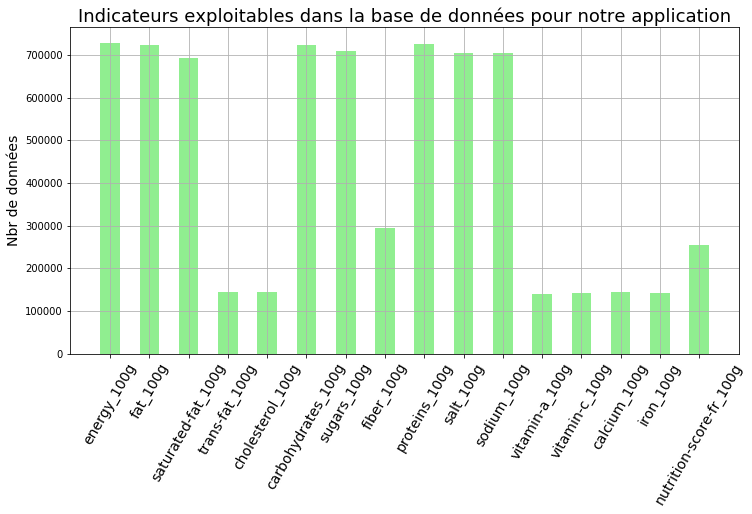

In [22]:
liste_colonnes = Champs_nutrition(df_travail)

df_donnees = df_travail.loc[:,liste_colonnes[0]:liste_colonnes[-1]].count()
df_donnees.sort_values(ascending=False)

#On trace le graphique correspondant en appelant la fonction écrite plus haut
labels = list(df_donnees.index)
sizes = list(df_donnees)

plt.subplots(figsize=(12, 6))
plt.bar(labels, sizes, width = 0.5, color = 'lightgreen')
plt.title("Indicateurs exploitables dans la base de données pour notre application",size=18)
plt.ylabel("Nbr de données",size=14)
plt.xticks(size=14, rotation=60)
plt.grid()

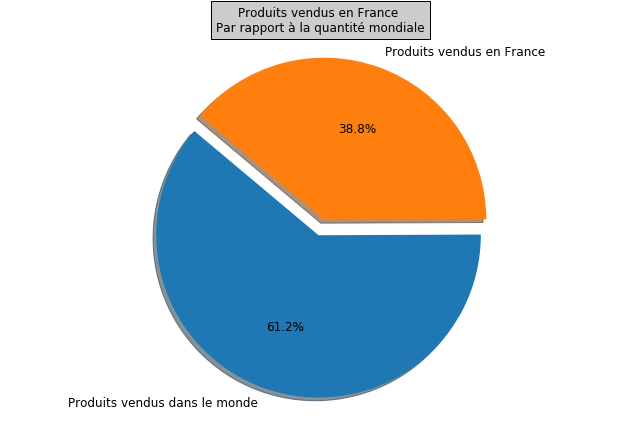

In [23]:

#On trace le graphique contenant la part de produits vendus en France
labels = ['Produits vendus dans le monde', 'Produits vendus en France']
sizes = [data.shape[0],vendus_France.shape[0]]
explode = (0, 0.1)
color = ['#ff9999','#66b3ff']

fig1, ax1 = plt.subplots(figsize=(9, 6))

ax1.pie(sizes, labels=labels,explode=explode, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 12})

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.title("Produits vendus en France \n" + "Par rapport à la quantité mondiale", bbox={'facecolor':'0.8', 'pad':5})
plt.tight_layout()
plt.show()

# Enregistrement du dataset de travail

Nous avons un dataset comportant :
 - Tous les produits vendus en France
 - Toutes les données nutritives exploitables en taux de remplissage de données
 - L'indicateur de grade nutritionnel
 - L'indicateur du groupe NOVA qui représente le degré de modification d'un produit
 - Les noms des produits.
 
Nous pouvons donc enregistrer ce dataset et commencer l'analyse des variables.

In [24]:
#On enregistre notre dataframe nettoyé pour les prochaines analyses
#vendus_France_nettoye.to_csv('produits_vendus_France.csv', index=False, encoding='utf-8', header=True, sep='\t')

# feather does not support serializing a non-default index
df_travail = df_travail.reset_index()
#data_nettoye.to_csv("produits_vendus_France.csv",index=False)
df_travail.to_feather("data_monde_outlier_100.ft")

## Une fois le nouveau dataset créé, on s'occupe des lignes dupliquées :

In [26]:
#On analyse les lignes dupliquées
#On recherche en premier les lignes dupliquées entièrement
produits_dupliques = vendus_France.loc[vendus_France.duplicated(keep=False),:]
produits_dupliques

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
366109,3217690055020,http://world-fr.openfoodfacts.org/produit/3217...,kiliweb,1554670701,2019-04-07T20:58:21Z,1556111603,2019-04-24T13:13:23Z,Syrup green apple,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366110,3217690055020,http://world-fr.openfoodfacts.org/produit/3217...,kiliweb,1554670701,2019-04-07T20:58:21Z,1556111603,2019-04-24T13:13:23Z,Syrup green apple,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563085,3700225107238,http://world-fr.openfoodfacts.org/produit/3700...,kiliweb,1558182525,2019-05-18T12:28:45Z,1558183963,2019-05-18T12:52:43Z,Lentilles corail,NaN,500 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563086,3700225107238,http://world-fr.openfoodfacts.org/produit/3700...,kiliweb,1558182525,2019-05-18T12:28:45Z,1558183963,2019-05-18T12:52:43Z,Lentilles corail,NaN,500 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
595023,3760124630473,http://world-fr.openfoodfacts.org/produit/3760...,openfoodfacts-contributors,1552607164,2019-03-14T23:46:04Z,1556658319,2019-04-30T21:05:19Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
595024,3760124630473,http://world-fr.openfoodfacts.org/produit/3760...,openfoodfacts-contributors,1552607164,2019-03-14T23:46:04Z,1556658319,2019-04-30T21:05:19Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
904305,8718546163784,http://world-fr.openfoodfacts.org/produit/8718...,teolemon,1544099493,2018-12-06T12:31:33Z,1544099563,2018-12-06T12:32:43Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
904306,8718546163784,http://world-fr.openfoodfacts.org/produit/8718...,teolemon,1544099493,2018-12-06T12:31:33Z,1544099563,2018-12-06T12:32:43Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#On supprime les lignes dupliquées
#On caonstate qu'il nous a bien supprimé 4 lignes sur les 8 identifiées précédemment
vendus_France_nettoye = vendus_France.drop_duplicates(keep='first')
vendus_France_nettoye.shape

(589299, 175)

In [28]:
#On analyse maintenant les produits dupliquées par leur code_barres

pd.set_option('display.max_columns', 175)
produits_dupliques = vendus_France_nettoye.loc[vendus_France_nettoye.duplicated(subset=['code'],keep=False),:]

produits_dupliques.shape

(176, 175)

In [29]:
#On réinitialise l'affichage de pandas
pd.reset_option("^display")

In [30]:
#Après analyse visuelle des lignes dupliquées par code barres, on se rends compte que ce ne sont que des doublons "ordinaires" avec les mêmes données nutritionnelles
#Nous pouvons donc les supprimer simplement
vendus_France_nettoye = vendus_France_nettoye.drop_duplicates(subset=['code'],keep='first')
vendus_France_nettoye.shape

(589211, 175)

In [31]:
nombre_lignes_supprimee = vendus_France.shape[0] - vendus_France_nettoye.shape[0]
nombre_lignes_supprimee

92

## Cette étape nous a permis de supprimer 92 lignes.

Anaysons le nouveau Dataset nettoyé.

In [32]:
vendus_France_nettoye.describe()

,created_t,last_modified_t,cities,allergens_fr,serving_quantity,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,5.892110e+05,5.892110e+05,0.0,0.0,6.144800e+04,0.0,209723.000000,209723.000000,0.0,209723.000000,...,9144.000000,197217.000000,197217.000000,3.000000,0.0,27.000000,1.000000,14.000000,22.000000,13.000000
mean,1.517257e+09,1.540663e+09,NaN,NaN,1.627392e+18,NaN,1.583422,0.054195,NaN,0.101424,...,635.628859,9.690782,9.397770,29.333333,NaN,0.068900,0.000045,5.085714,0.035588,0.051477
std,3.962441e+07,2.199975e+07,NaN,NaN,4.034095e+20,NaN,2.346092,0.229208,NaN,0.379433,...,6903.000160,8.742547,9.291241,15.011107,NaN,0.032583,NaN,5.082679,0.032069,0.156405
min,0.000000e+00,1.333873e+09,NaN,NaN,0.000000e+00,NaN,0.000000,0.000000,NaN,0.000000,...,0.049000,-15.000000,-15.000000,14.000000,NaN,0.008000,0.000045,0.400000,0.002110,0.006500
25%,1.508771e+09,1.532113e+09,NaN,NaN,3.000000e+01,NaN,0.000000,0.000000,NaN,0.000000,...,116.180000,2.000000,1.000000,22.000000,NaN,0.056500,0.000045,3.000000,0.021000,0.007000
50%,1.525958e+09,1.546992e+09,NaN,NaN,8.000000e+01,NaN,1.000000,0.000000,NaN,0.000000,...,343.415000,11.000000,10.000000,30.000000,NaN,0.069000,0.000045,3.950000,0.025000,0.007300
75%,1.541801e+09,1.554569e+09,NaN,NaN,1.500000e+02,NaN,2.000000,0.000000,NaN,0.000000,...,614.212500,16.000000,18.000000,37.000000,NaN,0.089000,0.000045,5.275000,0.040750,0.009500
max,1.563754e+09,1.563754e+09,NaN,NaN,1.000000e+23,NaN,30.000000,3.000000,NaN,5.000000,...,656298.600000,40.000000,40.000000,44.000000,NaN,0.130000,0.000045,21.500000,0.150000,0.572000


Nous avons un dataset filtré uniquement sur les produits vendus en France.

Celui-ci étant encore très lourd, nous allons créer un nouveau dataset contenant seulement les indicateurs dont nous avons besoin :

 - product_name : name of the product
 - generic_name
 - quantity : quantity and unit
 - brands
 - categories_fr
 - labels_fr
 - stores
 - nutrition_grade_fr : nutrition grade ('a' to 'e'). see http://fr.openfoodfacts.org/score-nutritionnel-experimental-france
 - main_category
 - main_category_fr
 - proteins_100g
 - fiber_100g
 - fruits-vegetables-nuts_100g
 - energy_100g
 - saturated-fat_100g
 - sugars_100g
 - sodium_100g
 - nutrition-score-fr_100g
 - nova_group

In [33]:
#On crée manuellement le dataset
data_nettoye = pd.DataFrame(vendus_France_nettoye['product_name'])
data_nettoye['generic_name'] = vendus_France_nettoye['generic_name']
data_nettoye['quantity'] = vendus_France_nettoye['quantity']
data_nettoye['brands'] = vendus_France_nettoye['brands']
data_nettoye['main_category'] = vendus_France_nettoye['main_category']
data_nettoye['main_category_fr'] = vendus_France_nettoye['main_category_fr']
data_nettoye['categories_fr'] = vendus_France_nettoye['categories_fr']
data_nettoye['labels_fr'] = vendus_France_nettoye['labels_fr']
data_nettoye['stores'] = vendus_France_nettoye['stores']
data_nettoye['nova_group'] = vendus_France_nettoye['nova_group']
data_nettoye['nutrition_grade_fr'] = vendus_France_nettoye['nutrition_grade_fr']
data_nettoye['nutrition-score-fr_100g'] = vendus_France_nettoye['nutrition-score-fr_100g']
data_nettoye['proteins_100g'] = vendus_France_nettoye['proteins_100g']
data_nettoye['fiber_100g'] = vendus_France_nettoye['fiber_100g']
data_nettoye['fruits-vegetables-nuts_100g'] = vendus_France_nettoye['fruits-vegetables-nuts_100g']
data_nettoye['energy_100g'] = vendus_France_nettoye['energy_100g']
data_nettoye['saturated-fat_100g'] = vendus_France_nettoye['saturated-fat_100g']
data_nettoye['sugars_100g'] = vendus_France_nettoye['sugars_100g']
data_nettoye['sodium_100g'] = vendus_France_nettoye['sodium_100g']

data_nettoye.shape

(589211, 19)

In [34]:
#On enlève les lignes qui ne contiennent que des NaN
data_nettoye.dropna(how='all', axis=0)
data_nettoye.shape

(589211, 19)

#### Ce nouveau dataset devient notre référence pour les prochaines analyses!

#### Faisons quelques analyses sur les produits disponibles :

In [35]:
#On filtre maintenant, à partir des produits vendus en France, ceux qui sont fabriqués en France.
fabriques_France = Filtre(vendus_France_nettoye,'manufacturing_places_tags','France')
fabriques_France.shape

(34198, 175)

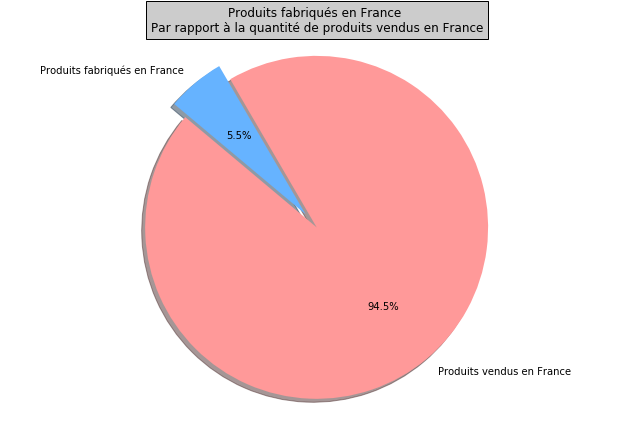

In [36]:
# On trace le graphique de l'analyse précédente

chart_pie(['Produits vendus en France', 'Produits fabriqués en France'], \
          [vendus_France_nettoye.shape[0],fabriques_France.shape[0]], \
          ['#ff9999','#66b3ff'], \
          (0, 0.1), \
         "Produits fabriqués en France \n" + "Par rapport à la quantité de produits vendus en France")

In [37]:
#On filtre maintenant, à partir des produits vendus en France, ceux qui sont vendus BIO.
produits_bio = Filtre(data_nettoye,'labels_fr','bio')
produits_bio.shape

(46937, 19)

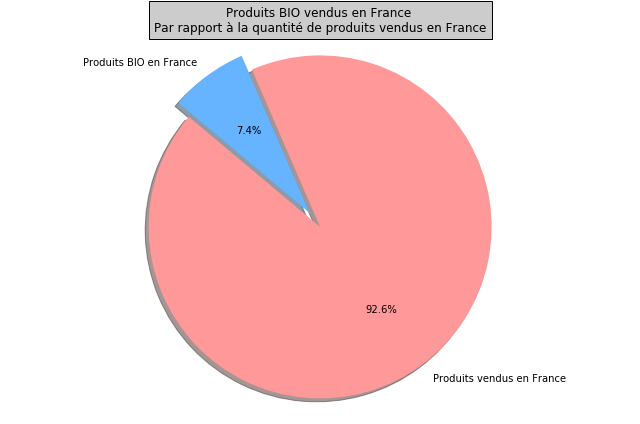

In [38]:
# On trace le graphique de l'analyse précédente

chart_pie(['Produits vendus en France', 'Produits BIO en France'], \
          [data_nettoye.shape[0],produits_bio.shape[0]], \
          ['#ff9999','#66b3ff'], \
          (0, 0.1), \
         "Produits BIO vendus en France \n" + "Par rapport à la quantité de produits vendus en France")

In [39]:
#On répertorie maintenant les produits par le classement Nutriscore :
categ_a = Filtre(data_nettoye,'nutrition_grade_fr','a').shape[0]
categ_b = Filtre(data_nettoye,'nutrition_grade_fr','b').shape[0]
categ_c = Filtre(data_nettoye,'nutrition_grade_fr','c').shape[0]
categ_d = Filtre(data_nettoye,'nutrition_grade_fr','d').shape[0]
categ_e = Filtre(data_nettoye,'nutrition_grade_fr','e').shape[0]

df_categ = pd.DataFrame({'A' : [categ_a], 'B' : [categ_b], 'C' : [categ_c], 'D' : [categ_d], 'E' : [categ_e]}, index = ["Nbr produits"])
df_categ               

,A,B,C,D,E
Nbr produits,25493,26128,41125,62232,42239


In [40]:
#On calcule le nombre de produits classifiés
total_classifies = categ_a + categ_b + categ_c + categ_d + categ_e
total_classifies

197217

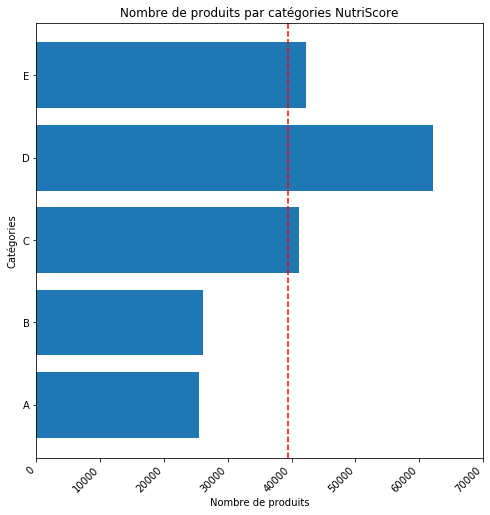

In [41]:

name = ['A','B','C','D','E']
data = [categ_a, categ_b, categ_c, categ_d, categ_e]

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(name, data)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')

# Add a vertical line, here we set the style in the function call
ax.axvline(total_classifies/5, ls='--', color='r')

ax.set(xlim=[0, 70000], xlabel='Nombre de produits', ylabel='Catégories',title="Nombre de produits par catégories NutriScore")

plt.show()


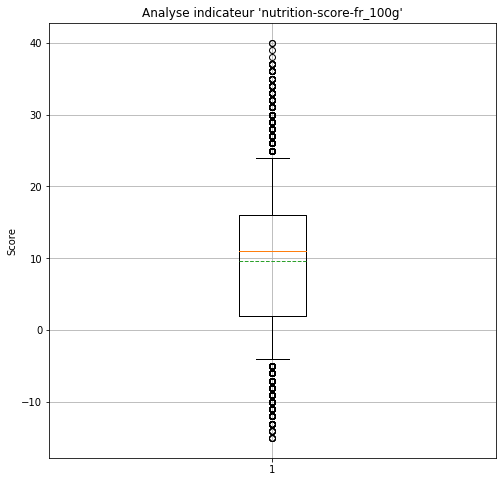

In [42]:
#Analyse des produits concernés par le nutriscore
data = data_nettoye['nutrition-score-fr_100g'].dropna()

fig, ax = plt.subplots(figsize=(8, 8))

ax.grid(True)

ax.boxplot(data,whis=[5,95],meanline=True,showmeans=True)

#On paramètre le graphique et on l'affiche
ax.set(title="Analyse indicateur 'nutrition-score-fr_100g'", ylabel='Score')

plt.show()

In [43]:
#On calcule le nombre de produits non concernés par le nutriscore
#Pour cela on compte le nombre de lignes nulles dans la colonne nutrition_grade_fr
non_categ = data_nettoye['nutrition_grade_fr'].isnull().sum().sum()
non_categ

391994

In [44]:
total_produits = total_classifies + non_categ
total_produits

589211

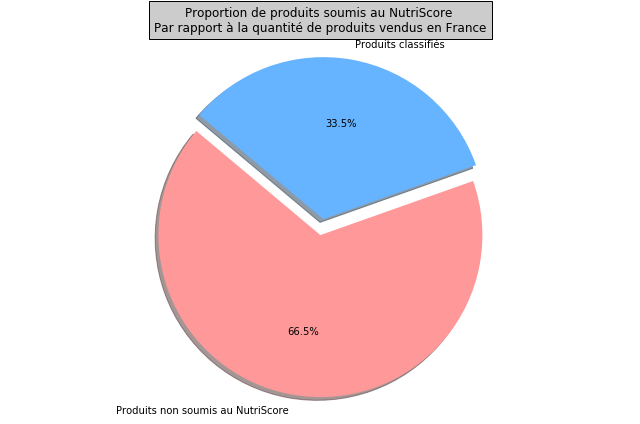

In [45]:
#On trace le graphique de l'analyse précédente

chart_pie(['Produits non soumis au NutriScore', 'Produits classifiés'], \
          [non_categ, total_classifies], \
          ['#ff9999','#66b3ff'], \
          (0, 0.1), \
         "Proportion de produits soumis au NutriScore \n" + "Par rapport à la quantité de produits vendus en France")


#### On se rend compte que 2/3 des produits ne sont pas soumis au NutriScore.

##### Cela peut-être dû à quatre facteurs :
 - Ce ne sont pas des produits alimentaires
 - Ces produits ne sont pas concernés par le NutriScore (Alcool, Fruits et Légumes frais par exemple)
 - Les sociétés ne sont pas obligées de se soumettre au NutriScore (A ce jour, il y a 164 sociétés qui participent à ce barême dans le monde, dont 156 an France. Source : https://world.openfoodfacts.org/label/nutriscore/brands)
 - Un manque de fiabilité de la BDD

In [46]:
#On filtre donc tous les produits non classés et on analyse les catégories restantes

non_classe = data_nettoye[data_nettoye['nutrition_grade_fr'].isnull()]
categ_non_classe = pd.DataFrame(non_classe['categories_fr'].unique())
categ_non_classe.head()

,0
0,NaN
1,Xsf
2,"Viandes,Volailles,Poulets,Aiguillettes de poulet"
3,"Produits de la mer,Poissons,Saumons,Pavés de s..."
4,"Aliments et boissons à base de végétaux,Alimen..."


##### L'analyse précédente ne nous éclaircit pas plus sur les produits non classifiés.

In [1]:
#On enregistre notre dataframe nettoyé pour les prochaines analyses
#vendus_France_nettoye.to_csv('produits_vendus_France.csv', index=False, encoding='utf-8', header=True, sep='\t')

# feather does not support serializing a non-default index
data_nettoye = data_nettoye.reset_index()
#data_nettoye.to_csv("produits_vendus_France.csv",index=False)
data_nettoye.to_feather("produits_vendus_France.ft")

NameError: name 'data_nettoye' is not defined